In [1]:
%load_ext autoreload
%autoreload 1

import glob
import numpy as np
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib widget

processed_directory = './data/processed_mats/*.mat'
acceptable_call_labels = ['Call', 'Stimulus', 'male_calls']  # any stimulus_trials containing call types NOT in this list are excluded (this includes unlabeled, which are stored as 'USV'!!)

files = [f for f in glob.glob(processed_directory)]

# or only specific files. Note: may mess up histograms, which may require data from >1 file
# files = [
#     './data/processed_mats/or60rd49-d1-20240425115050-Block1-PROCESSED.mat',
#     './data/processed_mats/or60rd49-d2-20240426114923-Block1-PROCESSED.mat'
# ]
files


['./data/processed_mats/or14pu27-d1-2024329115821-Block1-PROCESSED.mat',
 './data/processed_mats/pk81rd39-d2-20240403122107-Block1-PROCESSED.mat',
 './data/processed_mats/or13pu25_d2_20242141206-Block1-PROCESSED.mat',
 './data/processed_mats/pk44rd13-d1-20243271268-Block1-PROCESSED.mat',
 './data/processed_mats/pk81rd39-d1-20244212128-Block1-PROCESSED.mat',
 './data/processed_mats/pk63rd15-d1-2024312115724-Block1-PROCESSED.mat',
 './data/processed_mats/or54rd45-d1-20240423131059-Block1-PROCESSED.mat',
 './data/processed_mats/gr18bu69-d1-20240418115824-Block1-PROCESSED.mat',
 './data/processed_mats/gr3bu36-d2-20240515115449-Block1-PROCESSED.mat',
 './data/processed_mats/or54rd45-d2-20240424115748-Block1-PROCESSED.mat',
 './data/processed_mats/gr18bu69-d2-20240419122439-Block1-PROCESSED.mat',
 './data/processed_mats/pk44rd13-d2-2024328121232-Block1-PROCESSED.mat',
 './data/processed_mats/or14pu27-d2-2024330115149-Block1-PROCESSED.mat',
 './data/processed_mats/or13pu25_d120242131204-Block

In [2]:
%aimport utils.deepsqueak
from utils.deepsqueak import call_mat_stim_trial_loader, multi_index_from_dict

df = pd.DataFrame()

call_types_all = pd.DataFrame()
rejected_trials_all = pd.DataFrame()

for file in files:
    calls_df, stim_trials, rejected_trials, file_info, call_types = call_mat_stim_trial_loader(file, acceptable_call_labels=['Call', 'Stimulus'], verbose=False)

    multi_index_info = OrderedDict()
    multi_index_info['birdname'] = file_info['birdname']
    multi_index_info['day'] = int(file_info['day'])
    multi_index_info['block'] = int(file_info['block'])

    # create multiindex: birdname, stim_trial_index, call_index
    stim_trials = multi_index_from_dict(
        stim_trials, 
        multi_index_info, 
        keep_current_index=True,
    )
    df = pd.concat((df, stim_trials), axis='rows')
    
    rejected_trials = multi_index_from_dict(
        rejected_trials, 
        multi_index_info, 
        keep_current_index=True
    )
    rejected_trials_all = pd.concat((rejected_trials_all, rejected_trials), axis='rows')

    call_types = multi_index_from_dict(
        call_types, 
        multi_index_info, 
        keep_current_index=True
    )
    call_types_all = pd.concat((call_types_all, call_types), axis='rows')

print('Rejected trials:')
rejected_trials_all

Rejected trials:


,,,,trial_start_s,trial_end_s,stim_duration_s,calls_in_range
birdname,day,block,calls_index,,,,
or14pu27,1,1,1,3.809568,4.836454,0.155488,"[0, 2, 3, 4, 5]"
pk81rd39,2,1,5,4.466980,6.595487,0.127369,"[4, 6, 7, 8, 9]"
or13pu25,2,1,4,4.837572,7.406892,0.100969,[3]
gr3bu36,2,1,1,4.369790,6.905073,0.053104,[0]
or54rd45,2,1,1,4.541526,6.118070,0.142532,[0]
gr18bu69,2,1,1,4.423258,6.982666,0.088230,[0]
pk44rd13,2,1,4,3.966257,6.402687,0.061031,"[3, 5, 6]"
or14pu27,2,1,5,3.813216,5.290531,0.123968,[4]
or13pu25,1,1,43,16.594858,18.747674,0.144049,"[44, 45, 46, 47, 48]"


In [3]:
print(
    "Call types in rejected trials."
    + "Label `USV` means an accepted call was not given a label."
)

rejected_trial_call_types = call_types_all.loc[rejected_trials_all.index]
rejected_trial_call_types

# # see only blocks with a specific call type
#
# label = 'USV'
# label = 'Noise'
# call_types_all.loc[~np.isnan(call_types_all.loc[:, label])]

Call types in rejected trials.Label `USV` means an accepted call was not given a label.


,,,type,Call,Song,Loom wing flap
birdname,day,block,calls_index,,,
or14pu27,1,1,1,4.0,1.0,NaN
pk81rd39,2,1,5,4.0,NaN,1.0
or13pu25,2,1,4,NaN,NaN,1.0
gr3bu36,2,1,1,NaN,NaN,1.0
or54rd45,2,1,1,NaN,NaN,1.0
gr18bu69,2,1,1,NaN,NaN,1.0
pk44rd13,2,1,4,2.0,NaN,1.0
or14pu27,2,1,5,NaN,NaN,1.0
or13pu25,1,1,43,4.0,1.0,NaN


In [4]:
df

trial_start_s  trial_end_s  stim_duration_s  \
birdname day block stims_index                                                
or14pu27 1   1     0                 4.836454     6.881354         0.133217   
                   1                 6.881354     9.295725         0.143877   
                   2                 9.295725    12.090796         0.143149   
                   3                12.090796    14.503221         0.142879   
                   4                14.503221    17.287630         0.149183   
...                                       ...          ...              ...   
or60rd49 2   1     11               31.403146    34.086893         0.172858   
         1   1     0                 3.790657     5.186759         0.149184   
                   1                17.465298    20.158684         0.149183   
                   2                29.640861    31.779715         0.155915   
                   3                31.779715    34.086893         0.140951   

                                                  calls_in_range  \
birdname day block stims_index                                     
or14pu27 1   1     0                           [7, 8, 9, 10, 11]   
                   1                                [13, 14, 15]   
                   2                    [17, 18, 19, 20, 21, 22]   
                   3                                    [24, 25]   
                   4            [27, 28, 29, 30, 31, 32, 33, 34]   
...                                                          ...   
or60rd49 2   1     11                                       [31]   
         1   1     0                             [1, 2, 3, 4, 5]   
                   1                                        [20]   
                   2                                    [33, 34]   
                   3                                [36, 37, 38]   

                                                          call_times_stim_aligned  \
birdname day block stims_index                                                      
or14pu27 1   1     0            [[0.12448359581003388, 0.195836661349146], [0....   
                   1            [[0.1473379432374493, 0.20338823134640638], [1...   
                   2            [[0.2536706384905596, 0.38881993131402837], [0...   
                   3            [[0.2028818130493164, 0.2953310012817383], [0....   
                   4            [[0.19926424011502242, 0.32393684357233], [0.5...   
...                                                                           ...   
or60rd49 2   1     11                  [[0.7202426080363935, 0.8172858225928721]]   
         1   1     0            [[0.20650999486401211, 0.262653112411499], [0....   
                   1                      [[2.3112786519337654, 2.3764795617139]]   
                   2            [[0.24484489103303986, 0.2957980519514152], [1...   
                   3            [[0.24030110906523916, 0.2997072232863154], [0...   

                                n_calls  latency_s  \
birdname day block stims_index                       
or14pu27 1   1     0                  5   0.124484   
                   1                  3   0.147338   
                   2                  6   0.253671   
                   3                  2   0.202882   
                   4                  8   0.199264   
...                                 ...        ...   
or60rd49 2   1     11                 1   0.720243   
         1   1     0                  5   0.206510   
                   1                  1   2.311279   
                   2                  2   0.244845   
                   3                  3   0.240301   

                                                                     wav_filename  \
birdname day block stims_index                                                      
or14pu27 1   1     0            /Volumes/AnxietyBU/callbacks/or14pu27/d1-basel...   
                   1            /Volumes/AnxietyBU/call

In [5]:
all_birds = set(df.index.get_level_values(0))
all_birds

{'gr18bu69',
 'gr3bu36',
 'or13pu25',
 'or14pu27',
 'or54rd45',
 'or60rd49',
 'pk44rd13',
 'pk63rd15',
 'pk81rd39'}

## Plot Rasters

In [6]:
%%capture  
# to prevent plot output


%aimport utils.plot
from utils.plot import plot_callback_raster

save_folder =  None
save_folder = './data/figures/callback_rasters'

stim_kwargs = dict(color='red', alpha=0.5)
call_kwargs = dict(color='black', alpha=0.5)

# every bird/day/block
unique_conditions = list(set([a[0:3] for a in df.index]))

## or select a subset
# unique_conditions = [
#     ('or14pu27', 1, 1),
#     ('or14pu27', 2, 1),
#     ('or54rd45', 1, 1),
#     ('or54rd45', 2, 1),
# ]

# figs = {}

for bird, day, block in unique_conditions:

    fig = plt.figure()
    ax = fig.subplots()

    data = df.loc[(bird, day, block)]
    
    title_str = f'{bird}-d{day}-b{block}'

    plot_callback_raster(
        data,
        ax=ax,
        title = title_str,
        plot_stims = True,
        show_legend = True,
        call_kwargs = call_kwargs,
        stim_kwargs = stim_kwargs,
    )

    ax.set_xlim([-0.1, 3])

    # figs[title_str] = fig

    if save_folder is not None:
        fig.savefig(f'{save_folder}/{title_str}.png')

## Plot Latency Histograms

In [7]:
%%capture

# index levels: 'birdname', 'day', 'block', 'stims_index'
# idx = pd.IndexSlice
# this_bird = df.loc[idx[birdname, :, :, :]]

save_folder = None
save_folder = './data/figures/latency_histograms'
# save_folder = './data/figures'

from utils.plot import plot_group_hist

for birdname in set(df.index.get_level_values(0)):

    fig, ax = plt.subplots()

    plot_group_hist(
        df.loc[birdname],
        field="latency_s",
        grouping_level="day",
        group_colors={1: "#a2cffe", 2: "#840000"},
        alt_labels={1: "baseline", 2: "loom"},
        ax=ax,
        density=True,
        ignore_nan=True,
        histogram_kwargs={
            "range": (0, 1.5),
            "bins": 40,
        },
        stair_kwargs={
            1: {"hatch": "/"},
            2: {"hatch": "\\"},
        },
    )

    ax.set(
        title=f"{birdname}: latency to first call",
        xlabel="Latency (s)",
    )

    if save_folder is not None:
        fig.savefig(f'{save_folder}/{birdname}-latency-b1.png')

In [10]:
%%capture

save_folder = None
save_folder = "./data/figures/callcount_histograms"
# save_folder = './data/figures'

from utils.plot import plot_group_hist

for birdname in set(df.index.get_level_values(0)):

    fig, ax = plt.subplots()

    plot_group_hist(
        df.loc[birdname],
        field="n_calls",
        grouping_level="day",
        group_colors={1: "#a2cffe", 2: "#840000"},
        alt_labels={1: "baseline", 2: "loom"},
        ax=ax,
        density=True,
        ignore_nan=False,
        histogram_kwargs={
            "range": (-0.5, 9.5),
            "bins": 10,
        },
        stair_kwargs={
            1: {"hatch": "/"},
            2: {"hatch": "\\"},
        },
    )

    ax.set(
        title=f"{birdname}: number of calls per trial",
        xlabel="# of calls",
        xticks=list(range(0, 10)),
    )

    if save_folder is not None:
        fig.savefig(f"{save_folder}/{birdname}-ncalls-b1.png")

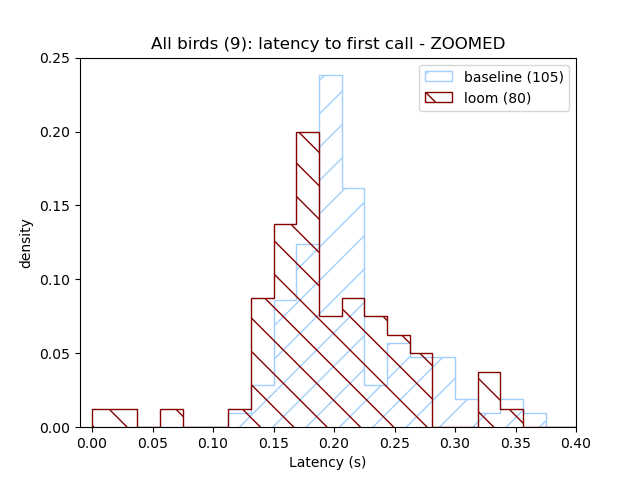

In [9]:
# %%capture

save_folder = None
save_folder = "./data/figures"

from utils.plot import plot_group_hist

fig, ax = plt.subplots()

plot_group_hist(
    df,
    field="latency_s",
    grouping_level="day",
    group_colors={1: "#a2cffe", 2: "#840000"},
    alt_labels={1: "baseline", 2: "loom"},
    ax=ax,
    density=True,
    ignore_nan=True,
    histogram_kwargs={
        "range": (0, 1.5),
        "bins": 80,
    },
    stair_kwargs={
        1: {"hatch": "/"},
        2: {"hatch": "\\"},
    },
)

ax.set(
    title=f"All birds ({len(all_birds)}): latency to first call",
    xlabel="Latency (s)",
)

if save_folder is not None:
    fig.savefig(f"{save_folder}/all_birds-latency-b1.png")

ax.set(
    xlim=[-0.01, 0.4],
    title=ax.get_title() + " - ZOOMED",
)

if save_folder is not None:
    fig.savefig(f"{save_folder}/all_birds-zoomed-latency-b1.png")

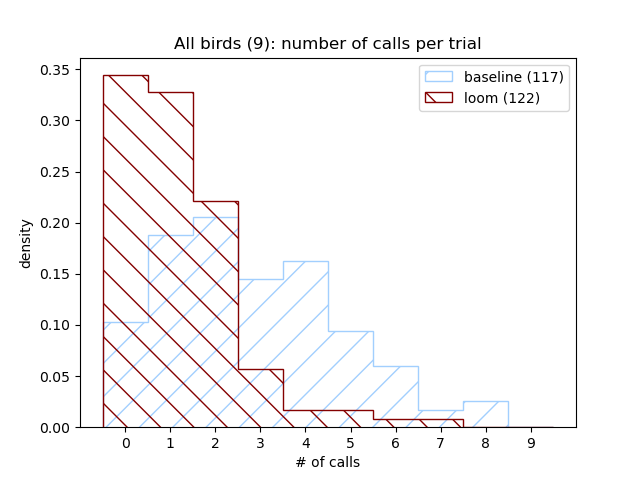

In [14]:
# %%capture

save_folder = None
save_folder = "./data/figures"

from utils.plot import plot_group_hist

fig, ax = plt.subplots()

plot_group_hist(
    df,
    field="n_calls",
    grouping_level="day",
    group_colors={1: "#a2cffe", 2: "#840000"},
    alt_labels={1: "baseline", 2: "loom"},
    ax=ax,
    density=True,
    ignore_nan=True,
    histogram_kwargs={
        "range": (-0.5, 9.5),
        "bins": 10,
    },
    stair_kwargs={
        1: {"hatch": "/"},
        2: {"hatch": "\\"},
    },
)

ax.set(
    title=f"All birds ({len(all_birds)}): number of calls per trial",
    xlabel="# of calls",
    xticks=list(range(0, 10)),
)

if save_folder is not None:
    fig.savefig(f"{save_folder}/all_birds-ncalls-b1.png")